In [32]:
import os, sys, json, datetime, random
import pandas as pd
import numpy as np
import numpy.linalg as la

import bokeh.plotting as bokeh_plt
from bokeh.io import show
from math import pi

from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt

import dcor

In [2]:
BASEDIRECTORY = "/Users/yifeihu/Downloads/111"
PATIENTINFO = "patient_info.json"

In [3]:
# patientInfo.json is a json file that contains information of patients staying in hospital and their records of being diagnosed as infected
patientInfoDict = {}
# load patient info from json file
with open("{}/{}".format(BASEDIRECTORY, PATIENTINFO)) as f:
    patientInfoDict = json.load(f)

In [4]:
def isClean(data: "ndarray") -> bool:
    """
    check whether the input dataframe is clean
    
    :param data: a 2-d ndarray retrieved by calling df.values
    :return: bool value indicating whether the input dataframe is clean
    """
    if (
        "***" in data
        or "+++" in data
        or "APN" in data
        or "ASY" in data
        or " VF" in data
        or "   " in data
        or "LRN" in data
        or "---" in data
    ):
        return False
    else:
        return True


def whatIsTheNoise(data: "ndarray") -> str:
    """
    check what is the noise among the input data
    
    :param data: a 2-d ndarray retrieved by calling df.values
    :return: str containing the outlier characters
    """
    retStr = ""

    if "***" in data:
        retStr += "***, "
    if "+++" in data:
        retStr += "+++, "
    if "APN" in data:
        retStr += "APN, "
    if "ASY" in data:
        retStr += "ASY, "
    if " VF" in data:
        retStr += " VF, "
    if "   " in data:
        retStr += "   , "
    if "LRN" in data:
        retStr += "LRN, "
    if "---" in data:
        retStr += "---, "

    if retStr == "":
        retStr = "All Clear!"

    return retStr


def calcMissingLine(df: "DataFrame") -> int:
    """
    calculate # of lines with missing values.
    
    :param df: the DataFrame to be analysed
    :return: # lines with missing values
    """
    count = 0

    df.replace("***", np.nan, inplace=True)
    df.replace("+++", np.nan, inplace=True)
    df.replace("APN", np.nan, inplace=True)
    df.replace("ASY", np.nan, inplace=True)
    df.replace(" VF", np.nan, inplace=True)
    df.replace("   ", np.nan, inplace=True)
    df.replace("LRN", np.nan, inplace=True)
    df.replace("---", np.nan, inplace=True)

    #     df = df.astype("float64")

    count = (df.isna().sum(axis=1) > 0).sum()

    return count


def calcMissingValue(df: "DataFrame") -> int:
    """
    calculate the missing ratio by value
    
    :param df: the DataFrame to be analysed
    :return: # missing values / # total values
    """
    df.replace("***", np.nan, inplace=True)
    df.replace("+++", np.nan, inplace=True)
    df.replace("APN", np.nan, inplace=True)
    df.replace("ASY", np.nan, inplace=True)
    df.replace(" VF", np.nan, inplace=True)
    df.replace("   ", np.nan, inplace=True)
    df.replace("LRN", np.nan, inplace=True)
    df.replace("---", np.nan, inplace=True)

    #     df = df.astype("float64")

    nMissing = df.isna().sum().sum()

    return nMissing


# calculate the missing ratio
# return: # lines with missing values / # total lines
def calcMissingRatio(dataframe):
    count = 0
    for i in dataframe.values:
        if (
            "***" in i
            or "+++" in i
            or "APN" in i
            or "ASY" in i
            or " VF" in i
            or "   " in i
            or "LRN" in i
            or "---" in i
        ):
            count += 1
    return count / len(dataframe)


# fill in missing values
# first with linear interpolation
# if it does not work fill with the nearest value
def fillMissing(dataframe):
    dataframe.replace("***", np.nan, inplace=True)
    dataframe.replace("+++", np.nan, inplace=True)
    dataframe.replace("APN", np.nan, inplace=True)
    dataframe.replace("ASY", np.nan, inplace=True)
    dataframe.replace(" VF", np.nan, inplace=True)
    dataframe.replace("   ", np.nan, inplace=True)
    dataframe.replace("LRN", np.nan, inplace=True)
    dataframe.replace("---", np.nan, inplace=True)

    dataframe = dataframe.astype("float64")

    dataframe.interpolate(inplace=True, limit_direction="both")
    dataframe.interpolate(inplace=True, method="nearest")

    return dataframe

In [5]:
# how many hours of data in total

nLines = 0
nLinesWithMissing = 0
nMissing = 0
nTotalValue = 0

dfList = []

fileNameList = os.listdir(BASEDIRECTORY)
for file in fileNameList:
    if os.path.isdir("{}/{}".format(BASEDIRECTORY, file)):
        fileNameListInCot = os.listdir("{}/{}".format(BASEDIRECTORY, file))
        for f in fileNameListInCot:
            if os.path.isdir("{}/{}/{}".format(BASEDIRECTORY, file, f)):
                if os.path.exists("{}/{}/{}/trend.txt".format(BASEDIRECTORY, file, f)):
                    tempfile = pd.read_csv(
                        "{}/{}/{}/trend.txt".format(BASEDIRECTORY, file, f)
                    )
                    dfList.append(tempfile)
                if os.path.exists("{}/{}/{}/trend1.txt".format(BASEDIRECTORY, file, f)):
                    tempfile = pd.read_csv(
                        "{}/{}/{}/trend1.txt".format(BASEDIRECTORY, file, f)
                    )
                    dfList.append(tempfile)

mergedDF = pd.concat(dfList)
mergedDF = mergedDF[["ART D", "ART M", "ART S", "HR", "SpO2", "RESP", "PLS", "25255"]]

print(len(mergedDF))
print(len(mergedDF) // 60)

1465781
24429


In [9]:
mergedDF = fillMissing(mergedDF)

In [7]:
mergedDF.index = np.arange(len(mergedDF))
mergedDF = mergedDF.astype("float64")

In [44]:
# descriptive statistics

print(mergedDF.mean())
print("********************")
print(mergedDF.max())
print("********************")
print(mergedDF.min())
print("********************")
print(mergedDF.median())
print("********************")
print(mergedDF.std())

ART D      3.920108
ART M      5.207061
ART S      6.921380
HR       155.948862
SpO2      95.259842
RESP      55.883115
PLS      156.315529
25255      1.491441
dtype: float64
********************
ART D    314.0
ART M    314.0
ART S    314.0
HR       297.0
SpO2     100.0
RESP     154.0
PLS      238.0
25255     20.0
dtype: float64
********************
ART D   -98.0
ART M   -13.0
ART S   -12.0
HR        0.0
SpO2      0.0
RESP      0.0
PLS       0.0
25255     0.0
dtype: float64
********************
ART D      0.00
ART M      0.00
ART S      0.00
HR       158.00
SpO2      97.00
RESP      54.00
PLS      158.00
25255      1.27
dtype: float64
********************
ART D    12.126074
ART M    15.687815
ART S    20.532966
HR       18.704205
SpO2      5.337553
RESP     20.906798
PLS      19.439352
25255     1.102477
dtype: float64


In [8]:
# Remove outliers

# Remove negatives
mergedDF[mergedDF < 0] = 0

# Remove zeros
mergedDF.replace(0, np.nan, inplace=True)
mergedDF.replace(0.0, np.nan, inplace=True)

In [46]:
print(mergedDF.mean())
print("********************")
print(mergedDF.max())
print("********************")
print(mergedDF.min())
print("********************")
print(mergedDF.median())
print("********************")
print(mergedDF.std())

ART D     35.961295
ART M     47.741996
ART S     63.435035
HR       156.065495
SpO2      95.320634
RESP      55.951172
PLS      156.414918
25255      1.492389
dtype: float64
********************
ART D    314.0
ART M    314.0
ART S    314.0
HR       297.0
SpO2     100.0
RESP     154.0
PLS      238.0
25255     20.0
dtype: float64
********************
ART D     1.00
ART M     1.00
ART S     1.00
HR        8.00
SpO2      5.00
RESP      1.00
PLS      26.00
25255     0.02
dtype: float64
********************
ART D     34.00
ART M     46.00
ART S     62.00
HR       158.00
SpO2      97.00
RESP      54.00
PLS      158.00
25255      1.27
dtype: float64
********************
ART D    13.977351
ART M    15.000340
ART S    16.678956
HR       18.218304
SpO2      4.765806
RESP     20.828313
PLS      19.041605
25255     1.102185
dtype: float64


In [8]:
nMissing = mergedDF.isna().sum().sum()
nTotal = mergedDF.shape[0] * mergedDF.shape[1]

print(calcMissingLine(mergedDF))
print(nMissing)
print(nTotal)

1419731
4350597
11726248


In [9]:
# missing value for each attributes
normal = np.load("normal.npy")
sepsis = np.load("sepsis.npy")

In [11]:
df_n = pd.DataFrame(normal.squeeze())
df_s = pd.DataFrame(sepsis.squeeze())

print(len(df_n), len(df_s))

1008969 163074


In [19]:
data = (1 - mergedDF.isna().sum() / mergedDF.shape[0]).sort_values()
print(data)

bokeh_plt.output_notebook()
p = bokeh_plt.figure(
    plot_height=400,
    x_axis_label="features",
    y_axis_label="presence ratio",
    x_range=list(data.index),
)
p.vbar(x=data.index, width=0.5, top=data)
p.xaxis.major_label_orientation = pi / 2
show(p)

ART D    0.041669
ART M    0.041679
ART S    0.041691
RESP     0.950084
SpO2     0.986722
PLS      0.988220
25255    0.988433
HR       0.993393
dtype: float64


Loading BokehJS ...

In [10]:
# patientInfo.json is a json file that contains information of patients staying in hospital and their records of being diagnosed as infected
patientInfoDict = {}
# load patient info from json file
with open(BASEDIRECTORY + "/patient_info.json") as f:
    patientInfoDict = json.load(f)

In [30]:
# iterate items in patientInfo.json
nSepsisPatient = 0
nNormalPatient = 0
for name in patientInfoDict:
    for temp in patientInfoDict[name]:
        if temp["sepsis"] != []:
            nSepsisPatient += 1
            break
nNormalPatient = len(patientInfoDict) - nSepsisPatient
print(nSepsisPatient)
print(nNormalPatient)

49
98


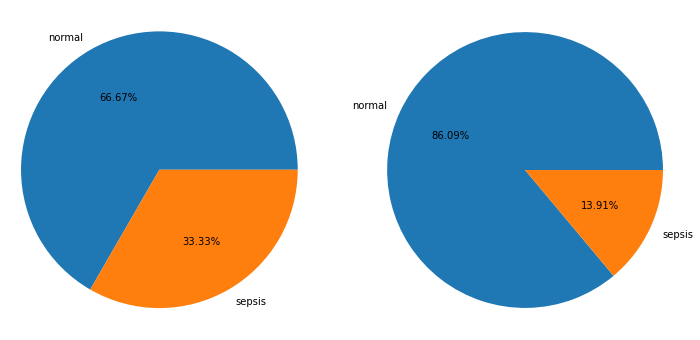

In [31]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
labels = ["normal", "sepsis"]
sizes = [98, 49]
colors = ["tab:blue", "tab:orange"]
plt.pie(sizes, labels=labels, colors=colors, autopct="%3.2f%%", shadow=False)
plt.axis("equal")

plt.subplot(122)
labels = ["normal", "sepsis"]
sizes = [1008969, 163074]
colors = ["tab:blue", "tab:orange"]
plt.pie(sizes, labels=labels, colors=colors, autopct="%3.2f%%", shadow=False)
plt.axis("equal")

plt.savefig("ratio_of_NICU.png")
plt.show()

In [11]:
# pearson correlation coefficeint
kept_features = ["HR", "RESP", "SpO2", "PLS", "25255"]
ppc_matrix = pd.DataFrame(
    np.zeros([len(kept_features), len(kept_features)]),
    index=kept_features,
    columns=kept_features,
)
pvalue_matrix = pd.DataFrame(
    np.zeros([len(kept_features), len(kept_features)]),
    index=kept_features,
    columns=kept_features,
)
for i in range(len(kept_features)):
    for j in range(len(kept_features)):
        pair = mergedDF[[kept_features[i], kept_features[j]]].dropna()
        #         print(pair[kept_features[i]])
        ppc = pearsonr(pair.iloc[:, 0].values, pair.iloc[:, 1].values)
        ppc_matrix.iloc[i][j] = ppc[0]
        pvalue_matrix.iloc[i][j] = ppc[1]

In [12]:
ppc_matrix

,HR,RESP,SpO2,PLS,25255
HR,1.000000,0.105690,-0.110499,0.920595,-0.087813
RESP,0.105690,1.000000,0.017137,0.096131,0.055374
SpO2,-0.110499,0.017137,1.000000,-0.065168,-0.085102
PLS,0.920595,0.096131,-0.065168,1.000000,-0.155734
25255,-0.087813,0.055374,-0.085102,-0.155734,1.000000


In [13]:
pvalue_matrix

,HR,RESP,SpO2,PLS,25255
HR,0.0,0.000000e+00,0.000000e+00,0.0,0.0
RESP,0.0,0.000000e+00,1.245426e-95,0.0,0.0
SpO2,0.0,1.245426e-95,0.000000e+00,0.0,0.0
PLS,0.0,0.000000e+00,0.000000e+00,0.0,0.0
25255,0.0,0.000000e+00,0.000000e+00,0.0,0.0


In [16]:
ppc_matrix.round(decimals=4).to_csv("ppc_matrix_NICU.csv")
pvalue_matrix.round(decimals=4).to_csv("pvalue_matrix_NICU.csv")

In [36]:
dcc_matrix = pd.DataFrame(
    np.zeros([len(kept_features), len(kept_features)]),
    index=kept_features,
    columns=kept_features,
)
for i in range(len(kept_features)):
    for j in range(len(kept_features)):
        pair = mergedDF[[kept_features[i], kept_features[j]]].dropna()
        #         print(pair[kept_features[i]])
        dcc = dcor.distance_correlation(pair.iloc[:, 0].values, pair.iloc[:, 1].values)
        dcc_matrix.iloc[i][j] = dcc

In [39]:
dcc_matrix.round(decimals=4).to_csv("dcc_NICU.csv")

In [57]:
# Relief algorithm
# An highlighted block
# _*_ coding:utf8 _*_

import time

"""
# 说明：特征选择方法一：过滤式特征选择（Relief算法）
# 思想：先用特征选择过程对初始特征进行"过滤"，然后再用过滤后的特征训练模型
# 时间：2019-1-14
# 问题：
"""

# 异常类
class FilterError:
    pass


class Filter:
    def __init__(self, data_df, sample_rate, t, k):
        """
        #
        :param data_df: 数据框（字段为特征，行为样本）
        :param sample_rate: 抽样比例
        :param t: 统计量分量阈值
        :param k: 选取的特征的个数
        """
        self.__data = data_df
        self.__feature = data_df.columns
        self.__sample_num = int(round(len(data_df) * sample_rate))
        self.__t = t
        self.__k = k

    # 数据处理（将离散型数据处理成连续型数据，比如字符到数值）
    def get_data(self):
        #         time.sleep(0.2)
        new_data = pd.DataFrame()
        for one in self.__feature[:-1]:
            col = self.__data[one]
            if (
                (str(list(col)[0]).split(".")[0]).isdigit()
                or str(list(col)[0]).isdigit()
                or (str(list(col)[0]).split("-")[-1]).split(".")[-1].isdigit()
            ):
                new_data[one] = self.__data[one]
            #                 print("%s 是数值型" % one)
            else:
                #                 print("%s 是离散型" % one)
                keys = list(set(list(col)))
                values = list(xrange(len(keys)))
                new = dict(zip(keys, values))
                new_data[one] = self.__data[one].map(new)
        new_data[self.__feature[-1]] = self.__data[self.__feature[-1]]
        return new_data

    # 返回一个样本的猜中近邻和猜错近邻
    def get_neighbors(self, row):
        df = self.get_data()
        row_type = row[df.columns[-1]]
        right_df = df[df[df.columns[-1]] == row_type].drop(columns=[df.columns[-1]])
        wrong_df = df[df[df.columns[-1]] != row_type].drop(columns=[df.columns[-1]])
        aim = row.drop(df.columns[-1])
        #         print(right_df.head())
        f = lambda x: eulidSim(np.mat(x.values), np.mat(aim))
        right_sim = right_df.apply(f, axis=1)
        right_sim_two = right_sim.drop(right_sim.idxmin())
        # print right_sim_two
        # print right_sim.values.argmax()   # np.argmax(wrong_sim)
        wrong_sim = wrong_df.apply(f, axis=1)
        # print wrong_sim
        # print wrong_sim.values.argmax()
        # print right_sim_two.idxmin(), wrong_sim.idxmin()
        return right_sim_two.idxmin(), wrong_sim.idxmin()

    # 计算特征权重
    def get_weight(self, feature, index, NearHit, NearMiss):
        data = self.__data.drop(self.__feature[-1], axis=1)
        row = data.iloc[index]
        nearhit = data.iloc[NearHit]
        nearmiss = data.iloc[NearMiss]
        if (
            (str(row[feature]).split(".")[0]).isdigit()
            or str(row[feature]).isdigit()
            or (str(row[feature]).split("-")[-1]).split(".")[-1].isdigit()
        ):
            max_feature = data[feature].max()
            min_feature = data[feature].min()
            right = pow(
                round(
                    abs(row[feature] - nearhit[feature]) / (max_feature - min_feature),
                    2,
                ),
                2,
            )
            wrong = pow(
                round(
                    abs(row[feature] - nearmiss[feature]) / (max_feature - min_feature),
                    2,
                ),
                2,
            )
            # w = wrong - right
        else:
            right = 0 if row[feature] == nearhit[feature] else 1
            wrong = 0 if row[feature] == nearmiss[feature] else 1
            # w = wrong - right
        w = wrong - right
        # print w
        return w

    # 过滤式特征选择
    def relief(self):
        sample = self.get_data()
        print(sample)
        #         time.sleep(0.1)
        #         print("暂停完了")
        m, n = np.shape(self.__data)  # m为行数，n为列数
        score = []
        sample_index = random.sample(range(0, m), self.__sample_num)
        print("采样样本索引为 %s " % sample_index)
        num = 1
        for i in sample_index:  # 采样次数
            one_score = dict()
            row = sample.iloc[i]
            NearHit, NearMiss = self.get_neighbors(row)
            print(
                "第 %s 次采样，样本index为 %s，其NearHit行索引为 %s ，NearMiss行索引为 %s"
                % (num, i, NearHit, NearMiss,)
            )
            for f in self.__feature[0:-1]:
                w = self.get_weight(f, i, NearHit, NearMiss)
                one_score[f] = w
                print("特征 %s 的权重为 %s." % (f, w))
            score.append(one_score)
            num += 1
        f_w = pd.DataFrame(score)
        print("采样各样本特征权重如下：")
        print(f_w)
        print("平均特征权重如下：")
        print(f_w.mean())
        return f_w.mean()

    # 返回最终选取的特征
    def get_final(self):
        f_w = pd.DataFrame(self.relief(), columns=["weight"])
        final_feature_t = f_w[f_w["weight"] > self.__t]
        print(final_feature_t)
        final_feature_k = f_w.sort_values("weight").head(self.__k)
        print(final_feature_k)
        return final_feature_t, final_feature_k


# 几种距离求解
def eulidSim(vecA, vecB):
    return la.norm(vecA - vecB)


def cosSim(vecA, vecB):
    """
    :param vecA: 行向量
    :param vecB: 行向量
    :return: 返回余弦相似度（范围在0-1之间）
    """
    num = float(vecA * vecB.T)
    denom = la.norm(vecA) * la.norm(vecB)
    cosSim = 0.5 + 0.5 * (num / denom)
    return cosSim


def pearsSim(vecA, vecB):
    if len(vecA) < 3:
        return 1.0
    else:
        return 0.5 + 0.5 * np.corrcoef(vecA, vecB, rowvar=0)[0][1]


# if __name__ == "__main__":
#     data = pd.read_csv("西瓜数据集3.csv")[
#         ["色泽", "根蒂", "敲击", "纹理", "脐部", "触感", "密度", "含糖率", "类别"]
#     ]
#     print data
#     f = Filter(data, 1, 0.8, 6)
#     f.relief()
#     # f.get_final()

In [15]:
# iterate items in patientInfo.json
labeled_df = pd.DataFrame()
for name in patientInfoDict:
    if name == "unknown":
        continue
    for entry in patientInfoDict[name]:
        sepsisTime = entry["sepsis"]
        duration = entry["duration"]
        durationList = []  # the dates that the patient is in hospital
        sepsisList = []  # the dates that the patient is infected
        delta = datetime.timedelta(days=1)

        for d in duration:
            d_start = datetime.datetime.strptime(d["start_date"], "%Y%m%d")
            d_end = datetime.datetime.strptime(d["end_date"], "%Y%m%d")
            while d_start <= d_end:
                durationList.append(datetime.datetime.strftime(d_start, "%Y%m%d"))
                d_start += delta
        durationList = list(set(durationList))  # get rid of the duplicates

        for s in sepsisTime:
            s_start = datetime.datetime.strptime(s["start_date"], "%Y%m%d")
            s_end = datetime.datetime.strptime(s["end_date"], "%Y%m%d")
            while s_start <= s_end:
                sepsisList.append(datetime.datetime.strftime(s_start, "%Y%m%d"))
                s_start += delta
        sepsisList = list(set(sepsisList))

        for date in durationList:
            temp = pd.read_csv(
                "%s/%s/%s/trend.txt" % (BASEDIRECTORY, "Cot" + entry["cot"], date)
            )[["HR", "RESP", "SpO2", "PLS", "25255"]]

            # we only use data with missing rate less than 10%
            if calcMissingRatio(temp) < 0.1:
                temp = fillMissing(temp)
            else:
                continue

            # if the patient has records of sepsis
            if date in sepsisList:
                temp["LABEL"] = 1
            else:
                temp["LABEL"] = 0

            labeled_df = labeled_df.append(temp)
            # if extra file of the patient exists
            if os.path.exists(
                "%s/%s/%s/trend1.txt" % (BASEDIRECTORY, "Cot" + entry["cot"], date)
            ):
                temp = temp.append(
                    pd.read_csv(
                        "%s/%s/%s/trend1.txt"
                        % (BASEDIRECTORY, "Cot" + entry["cot"], date)
                    )[["HR", "RESP", "SpO2", "PLS", "25255"]],
                    ignore_index=True,
                )
                if calcMissingRatio(temp) < 0.1:
                    temp = fillMissing(temp)
                else:
                    continue
                # if the patient has records of sepsis
                if date in sepsisList:
                    temp["LABEL"] = 1
                else:
                    temp["LABEL"] = 0

                labeled_df = labeled_df.append(temp)

/Users/yifeihu/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:109: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/yifeihu/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:110: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/yifeihu/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/yifeihu/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:112: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/yifeihu/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:113: FutureWarning: elementwise comp

In [37]:
reindexed = labeled_df.reset_index(drop=True)

In [42]:
reindexed.columns

Index(['HR', 'RESP', 'SpO2', 'PLS', '25255', 'LABEL'], dtype='object')

In [58]:
f = Filter(reindexed, 1, 0.8, 5)
f.relief()

            HR   RESP  SpO2    PLS  25255  LABEL
0        144.0   49.0  94.0  148.0   1.20      0
1        164.0   34.0  96.0  162.0   1.03      0
2        144.0   79.0  92.0  144.0   1.42      0
3        147.0   76.0  97.0  146.0   1.20      0
4        172.0   35.0  97.0  168.0   0.91      0
...        ...    ...   ...    ...    ...    ...
1177788  151.0   70.0  98.0  166.0   1.19      0
1177789  165.0   87.0  99.0  168.0   1.26      0
1177790  169.0  102.0  97.0  170.0   1.17      0
1177791  168.0   74.0  96.0  170.0   1.28      0
1177792  167.0   75.0  96.0  169.0   1.25      0

[1177793 rows x 6 columns]
暂停完了


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



第 1 次采样，样本index为 217538，其NearHit行索引为 6985 ，NearMiss行索引为 735866
特征 HR 的权重为 0.0.
特征 RESP 的权重为 0.0001.
特征 SpO2 的权重为 0.0.
特征 PLS 的权重为 0.0.
特征 25255 的权重为 0.0.
第 2 次采样，样本index为 968270，其NearHit行索引为 270689 ，NearMiss行索引为 421560
特征 HR 的权重为 0.0.
特征 RESP 的权重为 0.0.
特征 SpO2 的权重为 0.0.
特征 PLS 的权重为 0.0.
特征 25255 的权重为 0.003300000000000001.
第 3 次采样，样本index为 464481，其NearHit行索引为 623024 ，NearMiss行索引为 870886
特征 HR 的权重为 0.0.
特征 RESP 的权重为 0.0.
特征 SpO2 的权重为 0.0001.
特征 PLS 的权重为 0.0.
特征 25255 的权重为 -0.0001.


KeyboardInterrupt: 

In [30]:
reindexed.loc[0:1000, kept_features].shape

(1001, 5)